In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import  preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from qiskit import providers
from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [13]:
df = pd.read_csv('Datasets/Mentor/mock_train_set.csv')
df.head(8)

,0,1,2,3,x
0,2789.26,1000,10,20,0
1,4040.01,1000000,1,1,1
2,2931.20,10000,10000,40,1
3,3896.54,10000,100000,30,1
4,982.06,100,1000,75,0
5,1579.81,1,1000,90,0
6,3031.77,1000000,1000000,35,1
7,860.44,10,100000,60,0


In [40]:
df_test = pd.read_csv('Datasets/Mentor/mock_test_set.csv')
df_test.head(8)

,0,1,2,3,x
0,2988.55,10000,10000,75,1
1,3413.80,1,100,90,0
2,3891.52,1,1,5,0
3,4514.99,10000,1000000,25,1
4,752.29,10,10,90,0
5,1404.13,10000,1000,5,1
6,3390.65,1000000,10000,5,1
7,2620.98,1,10,75,0


In [14]:
f_name_list = list(df)
list(f_name_list)

['0', '1', '2', '3', 'x']

In [15]:
print('Number of empty data in the set: '), df.isnull().sum().sum()
clean_data = df.dropna()

Number of empty data in the set: 


In [16]:
#clean_data = clean_data.drop('Unnamed: 0', axis=1)
x_org = clean_data.drop('x', axis=1)
cat = clean_data.x

rel = ExtraTreesClassifier()
rel.fit(x_org, cat)

ExtraTreesClassifier()

In [17]:
print(rel.feature_importances_)

[0.13550175 0.47293591 0.28965961 0.10190273]


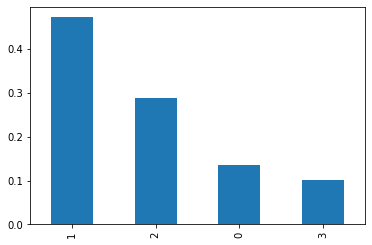

In [18]:
rank_f = pd.Series(rel.feature_importances_, index=x_org.columns)
rank_f.nlargest(20).plot(kind='bar')
plt.show()

In [19]:
corr = clean_data.iloc[:,:-1].corr()
classified = mutual_info_classif(x_org, cat)
class_data = pd.Series(classified, index=x_org.columns)
ordered_f = class_data.sort_values(ascending=False)

In [20]:
ordered_f.head(10)

1    0.327740
2    0.290102
0    0.060894
3    0.000000
dtype: float64

In [41]:
test_ratio = 0.2
seed = 1984
np.random.seed(seed)
selected_f = clean_data[['0','1','2','3','x']]
selected_test = df_test[['0','1','2','3','x']]

x_train = np.array(selected_f.drop('x', axis =1))
y_train = np.array(selected_f.x)
x = preprocessing.normalize(x_train, axis=0)

x_test = np.array(selected_test.drop('x', axis =1))
y_test = np.array(selected_test.x)
x = preprocessing.normalize(x_test, axis=0)

#x_train, x_test, y_train, y_test = train_test_split(x, cat, test_size=test_ratio, random_state=seed, stratify=cat)

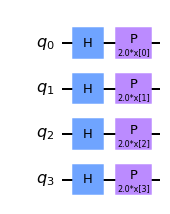

In [42]:
feature_dim = x.shape[1]
feature_map_layer = 1
ent = 'linear'

fmap = ZFeatureMap(feature_dimension=feature_dim, reps=feature_map_layer)#, entanglement=ent)
fmap.decompose().draw('mpl', scale=1)

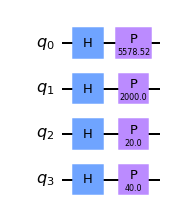

In [43]:
fmap.assign_parameters({k:v for (k,v) in zip(fmap.parameters, x_train[0])}).decompose().draw('mpl', scale=1)

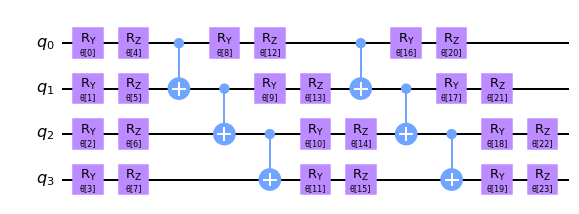

In [44]:
rotations = ['ry', 'rz']
var_form_rep = 2

ansatz_tl = TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)
ansatz_tl.decompose().draw('mpl', scale=1)

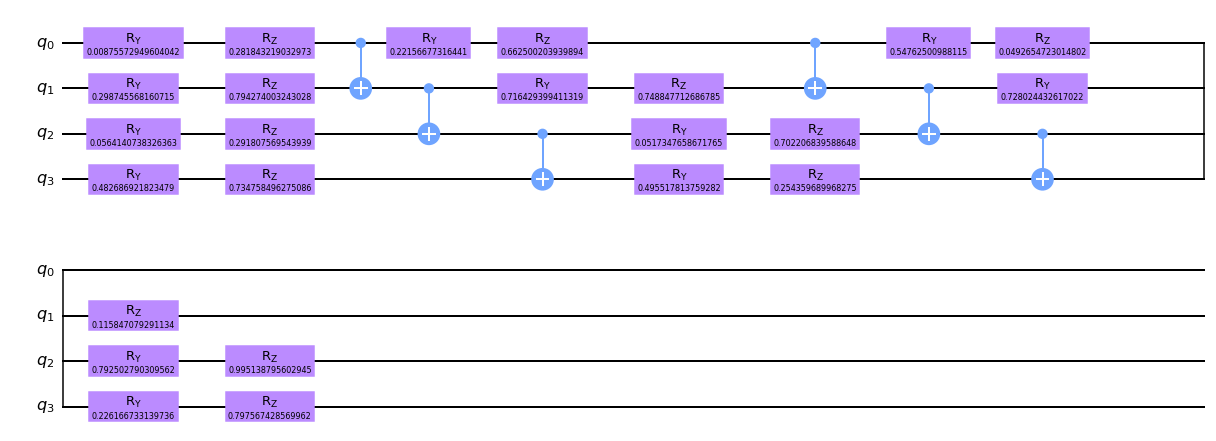

In [45]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=1)

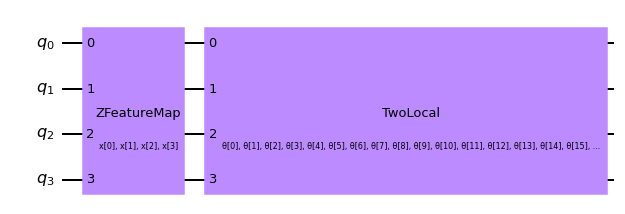

In [46]:
var_circuit = fmap.compose(ansatz_tl)
var_circuit.draw('mpl')

In [47]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [48]:
qasm_sim = Aer.get_backend('aer_simulator')
qinst = QuantumInstance(qasm_sim, 2048, seed_simulator=seed)

In [49]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [50]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.58007812, 0.41992188]])

In [51]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[-0.2277832 ,  0.00708008,  0.00512695,  0.00439453,
          0.10302734,  0.02075195,  0.12988281, -0.00073242,
          0.29418945,  0.00390625, -0.0090332 , -0.00415039,
          0.05981445,  0.02685547, -0.01074219, -0.00292969,
         -0.07885742,  0.00708008, -0.00097656,  0.00488281,
          0.00634766, -0.01147461, -0.01074219, -0.00585938],
        [ 0.2277832 , -0.00708008, -0.00512695, -0.00439453,
         -0.10302734, -0.02075195, -0.12988281,  0.00073242,
         -0.29418945, -0.00390625,  0.0090332 ,  0.00415039,
         -0.05981445, -0.02685547,  0.01074219,  0.00292969,
          0.07885742, -0.00708008,  0.00097656, -0.00488281,
         -0.00634766,  0.01147461,  0.01074219,  0.00585938]]])

In [52]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [53]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [54]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


# x_train_norm = np.array([x/np.linalg.norm(x) for x in x_train])
# x_test_norm = np.array([x/np.linalg.norm(x) for x in x_test])

vqc = vqc.fit(x_train, y_train_1h)

3 - 284.45019483090704
6 - 256.95995274624147
9 - 247.11335287284157
12 - 244.50337588940414
15 - 243.38695467061484
18 - 243.059183754685
21 - 239.13219024774585
24 - 220.52074520371775
27 - 219.37928357664333
30 - 219.3312571972129
33 - 216.906171280082
36 - 216.92079683913948
39 - 216.22698377901202
42 - 215.4012285588556
45 - 215.39002324394727
48 - 215.7079195551207
51 - 215.06962932851246
54 - 215.36814219766353
57 - 214.8983711114725
60 - 214.95113611037453
63 - 215.22252239595295
66 - 214.84988601361806
69 - 214.7235820678044
72 - 214.6792148963239
75 - 214.26906056247765
78 - 214.1266760845078
81 - 213.89001802832743
84 - 214.0198197975879
87 - 214.18054038450612
90 - 213.85580880860346
93 - 214.05757464988653
96 - 214.2273277810695
99 - 214.24466535892088
102 - 214.07920701723245
105 - 214.05759174217226
108 - 214.19286473957197
111 - 214.09428551588258
114 - 214.3356882662418
117 - 214.2344297892392
120 - 214.3818182225367
123 - 214.14090782753254
126 - 214.2627533682381
129

In [55]:
score_train = vqc.score(x_train, y_train_1h)
score_test = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.7966666666666666
Score on the test set 0.8166666666666667


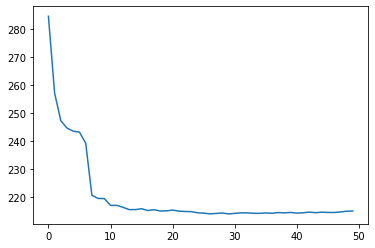

In [56]:
plt.plot(loss_recorder)